In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import glob
import os

from scipy.stats import trim_mean
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 

%matplotlib inline

# 한글 폰트 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [3]:
input_file = r'C:\Users\gby1349\python\공모전\data' 

all_file_list = glob.glob(os.path.join(input_file, 'buy*'))
all_data = [] 

for file in all_file_list:
    df = pd.read_csv(file) 
    df.columns = ['num','data','sex','age','big_cat','sm_cat','qty']
    all_data.append(df)
    
buy_data = pd.concat(all_data, axis=0, ignore_index=True)

In [4]:
buy_data['year'] = buy_data['data'].astype('str').astype('datetime64').dt.year
buy_data['month'] = buy_data['data'].astype('str').astype('datetime64').dt.month
buy_data['day'] = buy_data['data'].astype('str').astype('datetime64').dt.day
buy_data['Day_of_week'] = (buy_data['data'].astype('str').astype('datetime64').
                           apply(lambda x: ('월','화','수','목','금','토','일')[x.weekday()]))
buy_data.head()

,num,data,sex,age,big_cat,sm_cat,qty,year,month,day,Day_of_week
0,1,20180101,F,20,식품,가공란,37,2018,1,1,월
1,2,20180101,F,30,식품,가공란,16,2018,1,1,월
2,3,20180101,F,40,식품,가공란,9,2018,1,1,월
3,4,20180101,F,50,식품,가공란,3,2018,1,1,월
4,5,20180101,M,20,식품,가공란,13,2018,1,1,월


In [5]:
buy_data.tail()

,num,data,sex,age,big_cat,sm_cat,qty,year,month,day,Day_of_week
2056894,528636,20191231,M,20,냉난방가전,히터,8,2019,12,31,화
2056895,528637,20191231,M,30,냉난방가전,히터,22,2019,12,31,화
2056896,528638,20191231,M,40,냉난방가전,히터,38,2019,12,31,화
2056897,528639,20191231,M,50,냉난방가전,히터,23,2019,12,31,화
2056898,528640,20191231,M,60,냉난방가전,히터,10,2019,12,31,화


## EDA 그리기

#### 1번 나이와 성별관련 EDA
(1) 전체 구매 건수(qty 합)의 성별과 니이대의 비율: 성별, 나이대로 얼마나 구매했는가?
- 여성 / 30 - 40대의 구매 건수 비율이 높음

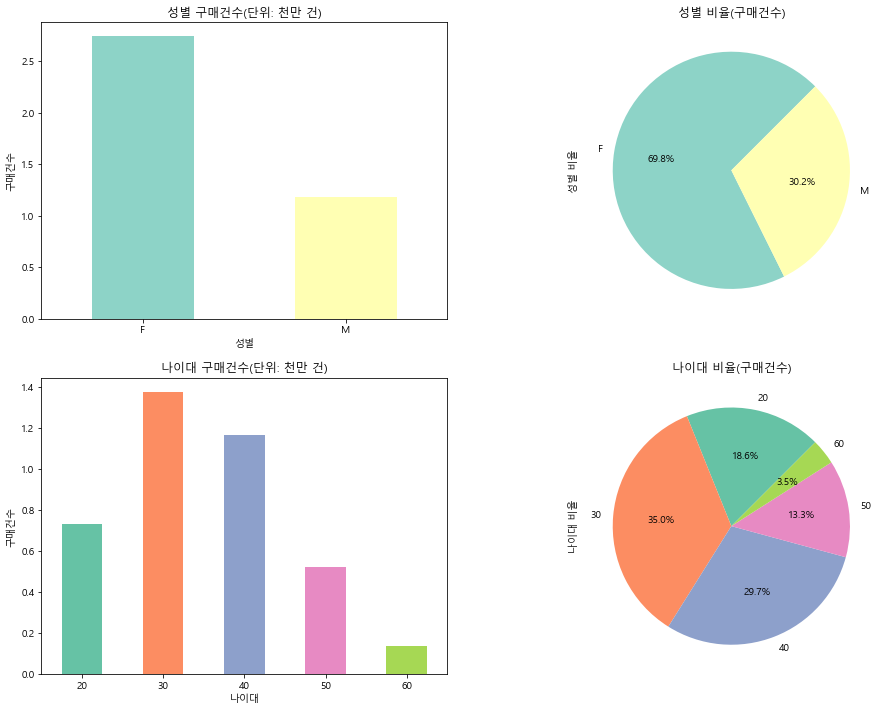

In [6]:
sex_age_pivot = pd.pivot_table(buy_data, index= 'age', columns = 'sex', values = 'qty', aggfunc = 'sum', margins = True)

fig, axes = plt.subplots(2,2, figsize = (16,12))
colors1 = matplotlib.cm.get_cmap('Set3')(np.arange(2))
(sex_age_pivot.iloc[-1,:-1]/ 1e7).plot.bar(ax= axes[0,0], color = colors1, rot = 0)
axes[0,0].set_title("성별 구매건수(단위: 천만 건)")
axes[0,0].set_xlabel('성별')
axes[0,0].set_ylabel('구매건수')

sex_age_pivot.iloc[-1,:-1].plot.pie(autopct = "%.1f%%",  startangle = 45, ax = axes[0,1], colors = colors1)
axes[0,1].set_title("성별 비율(구매건수)")
axes[0,1].set_ylabel('성별 비율')

colors2 = matplotlib.cm.get_cmap('Set2')(np.arange(5))
(sex_age_pivot.iloc[:-1,-1]/ 1e7).plot.bar(ax= axes[1,0], color = colors2, rot = 0)
axes[1,0].set_title("나이대 구매건수(단위: 천만 건)")
axes[1,0].set_xlabel('나이대')
axes[1,0].set_ylabel('구매건수')


sex_age_pivot.iloc[:-1,-1].plot.pie(autopct = "%.1f%%",  startangle = 45, ax = axes[1,1], colors = colors2)
axes[1,1].set_title("나이대 비율(구매건수)")
axes[1,1].set_ylabel('나이대 비율')

plt.show()

(3) 나이대별 성별의 구매건수 비율 / 성별별 나이대 구매건수 비율

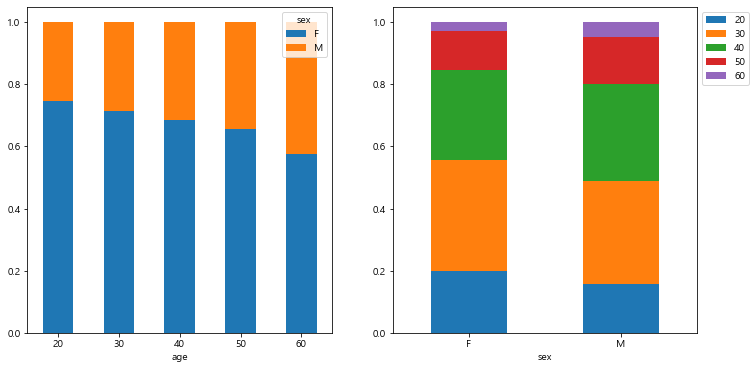

In [7]:
age_ratio = sex_age_pivot.divide(sex_age_pivot['All'], axis = 0).iloc[:-1, :-1]
sex_ratio = sex_age_pivot.divide(sex_age_pivot.loc['All', :], axis = 1).iloc[:-1, :-1]

fig, axes = plt.subplots(1,2, figsize = (12,6))
age_ratio.plot.bar(ax = axes[0], stacked = True, rot = 0)
sex_ratio.T.plot.bar(ax = axes[1], stacked = True, rot = 0)
axes[1].legend(bbox_to_anchor = (1.0, 1.0))
plt.show()

#### 2번  요일별(월~일) 성별 / 나이대 총구매건수의 변화 확인(선 그래프)
1. 주말(토)과 휴일(일)의 총 구매건수가 감소하는 경향
2. 여성이 남성의 비해 구매 건수가 압도저럭 큼

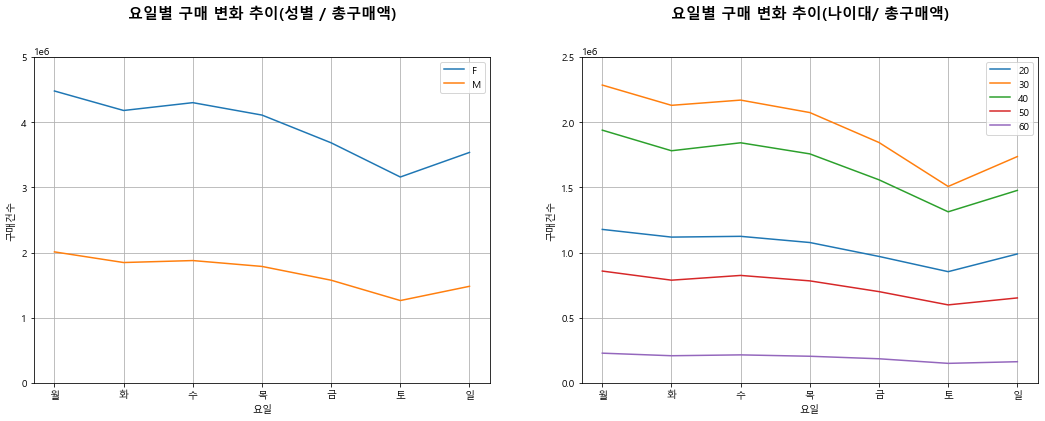

In [8]:
week_by_sex = pd.pivot_table(buy_data, index= 'sex', columns = 'Day_of_week', values = 'qty', aggfunc = 'sum')
week_by_sex  = week_by_sex[['월','화','수','목','금','토','일']]

week_by_age = pd.pivot_table(buy_data, index= 'age', columns = 'Day_of_week', values = 'qty', aggfunc = 'sum')
week_by_age = week_by_age[['월','화','수','목','금','토','일']]

fig, axes= plt.subplots(1, 2, figsize = (18,6))
week_by_sex.T.plot(ax= axes[0])
axes[0].set_title("요일별 구매 변화 추이(성별 / 총구매액)", fontdict = {'fontsize': 15, 'fontweight':'bold'}, y= 1.1)
axes[0].legend(bbox_to_anchor=(1.0, 1.0))
axes[0].grid(True)
axes[0].set_xlabel("요일")
axes[0].set_ylabel('구매건수')
axes[0].set_ylim(0,5e6)

week_by_age.T.plot(ax= axes[1])
axes[1].set_title("요일별 구매 변화 추이(나이대/ 총구매액)", fontdict = {'fontsize': 15, 'fontweight':'bold'}, y= 1.1)
axes[1].legend(bbox_to_anchor=(1.0, 1.0))
axes[1].grid(True)
axes[1].set_xlabel("요일")
axes[1].set_ylabel('구매건수')
axes[1].set_ylim(0,2.5e6)

plt.show()

#### 3번 월별(1~12월) 성별 / 나이대 총구매건수의 변화 확인(선 그래프)

1. 1월, 5월의 구매가 많음 
2. 2월, 6월, 9월의 구매가 떨어짐

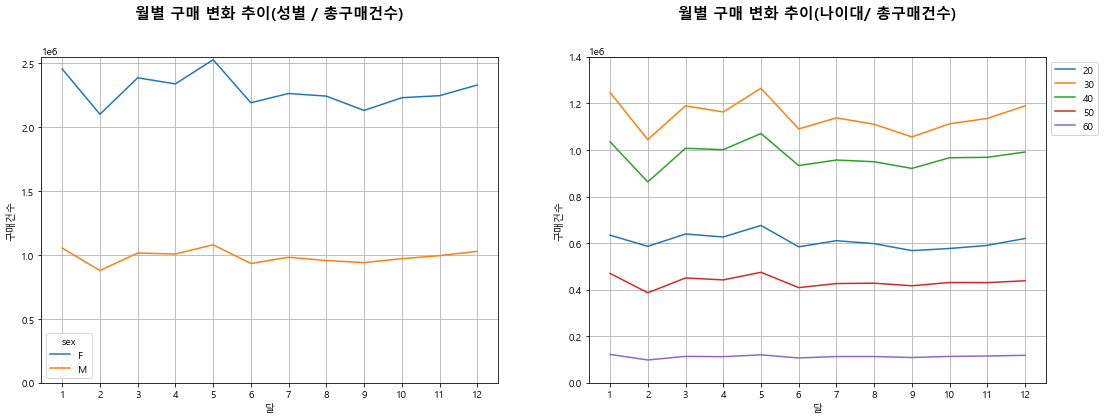

In [9]:
month_by_sex = pd.pivot_table(buy_data, index= 'sex', columns = 'month', values = 'qty', aggfunc = 'sum')
month_by_age = pd.pivot_table(buy_data, index= 'age', columns = 'month', values = 'qty', aggfunc = 'sum')

fig, axes= plt.subplots(1, 2, figsize = (18,6))
month_by_sex.T.plot(ax= axes[0])
axes[0].set_title("월별 구매 변화 추이(성별 / 총구매건수)", fontdict = {'fontsize': 15, 'fontweight':'bold'}, y= 1.1)
axes[0].set_xlabel("달")
axes[0].set_ylabel('구매건수')
axes[0].set_xticks(np.arange(1,13,1))
axes[0].grid(True)
axes[0].set_ylim(0,2.55e6)

month_by_age.T.plot(ax= axes[1])
axes[1].set_title("월별 구매 변화 추이(나이대/ 총구매건수)", fontdict = {'fontsize': 15, 'fontweight':'bold'}, y= 1.1)
axes[1].set_xlabel("달")
axes[1].set_ylabel('구매건수')
axes[1].set_xticks(np.arange(1,13,1))
axes[1].grid(True)
axes[1].set_ylim(0,1.4e6)
axes[1].legend(bbox_to_anchor=(1.0, 1.0))

plt.show()

#### 4번 일별(1~31일) 성별 / 나이대 총구매건수의 변화 확인(선 그래프)

1. 일별로는 판단하기 어려움

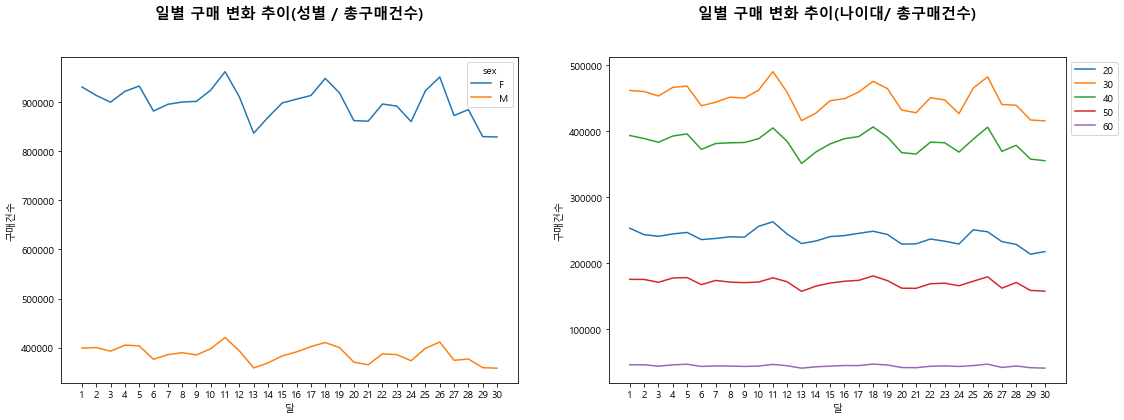

In [9]:
day_by_sex = pd.pivot_table(buy_data, index= 'sex', columns = 'day', values = 'qty', aggfunc = 'sum')
day_by_sex = day_by_sex.iloc[:,:-1]
day_by_age = pd.pivot_table(buy_data, index= 'age', columns = 'day', values = 'qty', aggfunc = 'sum')
day_by_age = day_by_age.iloc[:,:-1]

fig, axes= plt.subplots(1, 2, figsize = (18,6))
day_by_sex.T.plot(ax= axes[0])
axes[0].set_title("일별 구매 변화 추이(성별 / 총구매건수)", fontdict = {'fontsize': 15, 'fontweight':'bold'}, y= 1.1)
axes[0].set_xlabel("달")
axes[0].set_ylabel('구매건수')
axes[0].set_xticks(np.arange(1,31,1))


day_by_age.T.plot(ax= axes[1])
axes[1].set_title("일별 구매 변화 추이(나이대/ 총구매건수)", fontdict = {'fontsize': 15, 'fontweight':'bold'}, y= 1.1)
axes[1].set_xlabel("달")
axes[1].set_ylabel('구매건수')
axes[1].set_xticks(np.arange(1,31,1))
axes[1].legend(bbox_to_anchor=(1.0, 1.0))

plt.show()

#### 5번 big_cat의 EDA(성별, 나이별 구매 건수 비율)
(1) 성별로 어떤 종류의 상품 구매 건수비율이 되는가

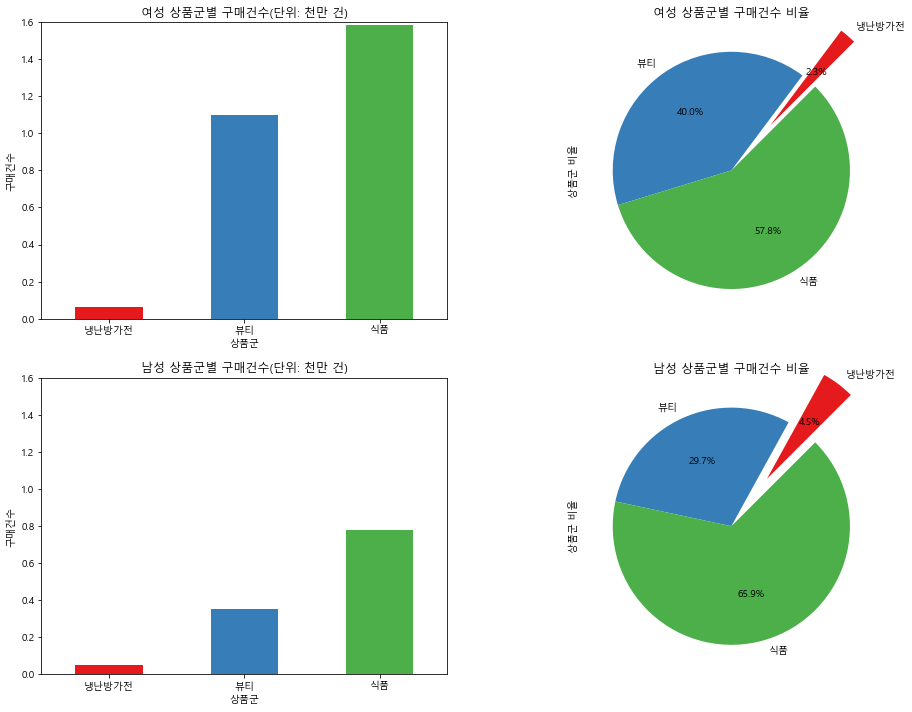

In [10]:
big_cat_by_sex = pd.pivot_table(buy_data, index= 'sex', columns = 'big_cat', values = 'qty', aggfunc = 'sum',margins = True)
fig, axes = plt.subplots(2,2, figsize = (16,12))

colors1 = matplotlib.cm.get_cmap('Set1')(np.arange(3))
(big_cat_by_sex.iloc[0,:-1] / 1e7).plot.bar(ax= axes[0,0], color = colors1, rot = 0)
axes[0,0].set_title("여성 상품군별 구매건수(단위: 천만 건)")
axes[0,0].set_xlabel('상품군')
axes[0,0].set_ylabel('구매건수')
axes[0,0].set_ylim(0, 1.6)

big_cat_by_sex.iloc[0,:-1].plot.pie(autopct = "%.1f%%",  startangle = 45, ax = axes[0,1], colors = colors1, explode = (0.5,0, 0))
axes[0,1].set_title("여성 상품군별 구매건수 비율")
axes[0,1].set_ylabel('상품군 비율')

(big_cat_by_sex.iloc[1,:-1] / 1e7).plot.bar(ax= axes[1,0], color = colors1, rot = 0)
axes[1,0].set_title("남성 상품군별 구매건수(단위: 천만 건)")
axes[1,0].set_xlabel('상품군')
axes[1,0].set_ylabel('구매건수')
axes[1,0].set_ylim(0, 1.6)

big_cat_by_sex.iloc[1,:-1].plot.pie(autopct = "%.1f%%",  startangle = 45, ax = axes[1,1], colors = colors1, explode = (0.5,0, 0))
axes[1,1].set_title("남성 상품군별 구매건수 비율")
axes[1,1].set_ylabel('상품군 비율')

plt.show()

(2) 각 대분류 상품(냉난방가전, 뷰티, 식품)에 대한 나이대별 구매건수 
- 전반적으로 30대 구매건수가 높다(왜곡의 가능성이 있으므로 비율로 보자)

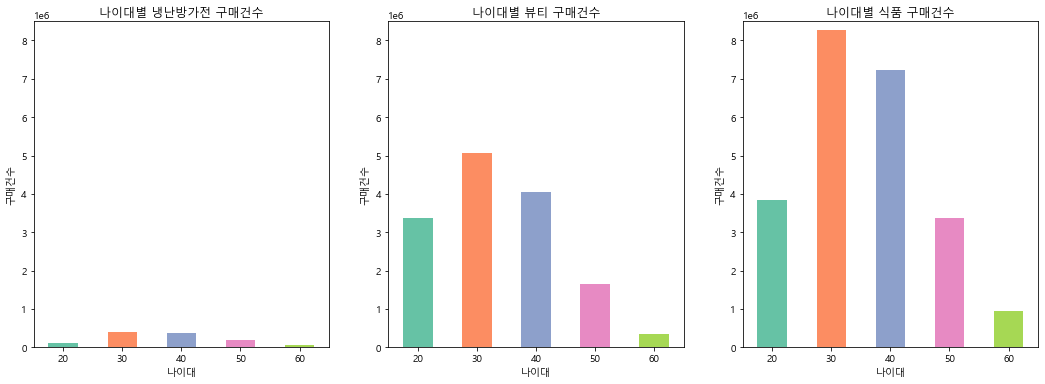

In [11]:
big_cat_by_age = pd.pivot_table(buy_data, index= 'age', columns = 'big_cat', values = 'qty', aggfunc = 'sum',margins = True)
colors4 = matplotlib.cm.get_cmap('Set2')(np.arange(5))

fig, axes = plt.subplots(1,3, figsize = (18,6))

for i in range(3):
    big_cat_by_age.iloc[:-1,i].plot.bar(ax = axes[i], color = colors4,rot = 0)
    axes[i].set_title('나이대별 {} 구매건수'.format(big_cat_by_age.iloc[:-1,i].name))
    axes[i].set_xlabel('나이대')
    axes[i].set_ylabel('구매건수')
    axes[i].set_ylim(0, 8500000)

#### (3) 각 대분류 상품(냉난방가전, 뷰티, 식품)에 대한 나이대별 구매건수 비율

- 나이대가 높아질수록 식품의 비율이 높아짐 / 나이대가 낮을수록 뷰티의 비율이 높아짐

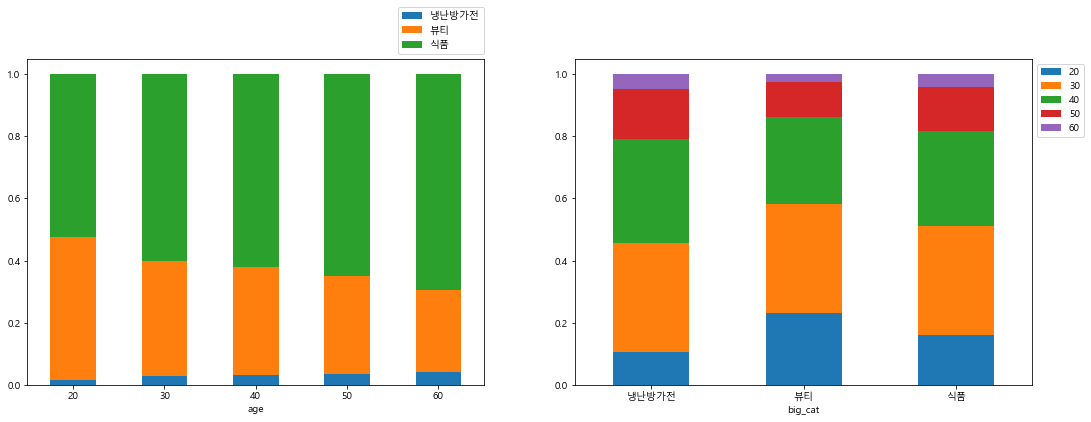

In [12]:
big_cat_ageratio = big_cat_by_age.divide(big_cat_by_age['All'], axis = 0).iloc[:-1, :-1]
big_cat_catratio = big_cat_by_age.divide(big_cat_by_age.loc['All', :], axis = 1).iloc[:-1, :-1]

fig, axes = plt.subplots(1,2, figsize = (18,6))
big_cat_ageratio.plot.bar(ax = axes[0], stacked = True, rot = 0)
big_cat_catratio.T.plot.bar(ax = axes[1], stacked = True, rot = 0)
axes[0].legend(bbox_to_anchor = (0.8, 1.0))
axes[1].legend(bbox_to_anchor = (1.0, 1.0))
plt.show()

#### 7번

In [190]:
def top30_buy(product_sort):
    product = buy_data.loc[buy_data.big_cat == product_sort,:]
    
    top30_total =  pd.pivot_table(product, index= 'sm_cat', values = 'qty', aggfunc = 'sum')
    top30_total = top30_total.sort_values(by='qty',ascending = False)[:30]

    plt.figure(figsize = (15, 6))
    sns.barplot(y=top30_total .index, x='qty', data = top30_total , orient = 'h')
    plt.title("{} TOP 구매 순위".format(product_sort))
    plt.show()
    
    rank_bysex = pd.pivot_table(product, index= 'sm_cat', columns = 'sex', values = 'qty', aggfunc = 'sum')

    man_top30= rank_bysex.sort_values(by='M',ascending = False)[:30]
    woman_top30 = rank_bysex.sort_values(by='F',ascending = False)[:30]

    fig, axes = plt.subplots(2,1, figsize = (18,24))
    sns.barplot(y=man_top30.index, x='M', data = man_top30, ax = axes[0], orient = 'h')
    axes[0].set_title("남성 {} TOP 구매 순위".format(product_sort))

    sns.barplot(y=woman_top30.index, x='F', data = woman_top30, ax = axes[1], orient = 'h')
    axes[1].set_title("여성 {} 상품 구매 순위(남성과 비교)".format(product_sort))
    plt.show()
    
    rank_byage = pd.pivot_table(product, index= 'sm_cat' ,columns = 'age', values = 'qty', aggfunc = 'sum')

    age = [20, 30, 40, 50, 60]

    fig, axes = plt.subplots(5,1, figsize = (18,60))
    for i in range(5):
        ages = age[i] 
        value = rank_byage.sort_values(by=ages ,ascending = False)[:30]
        sns.barplot(y=value.index, x= ages, data = value, ax = axes[i], orient = 'h')
        axes[i].set_title("{}대 {} TOP 30 순위".format(ages, product_sort))

(1) 식품 中 상위 구매 건수 30개 항목(전체건수, 성별, 나이대별 구매 건수 상위 30개 항목)

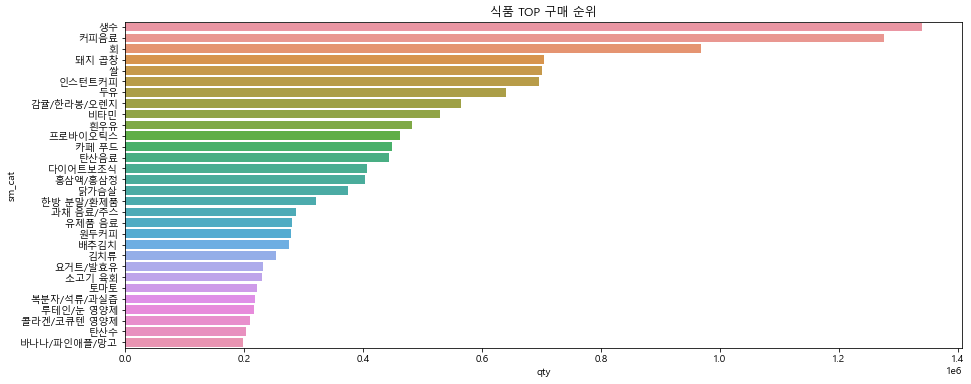

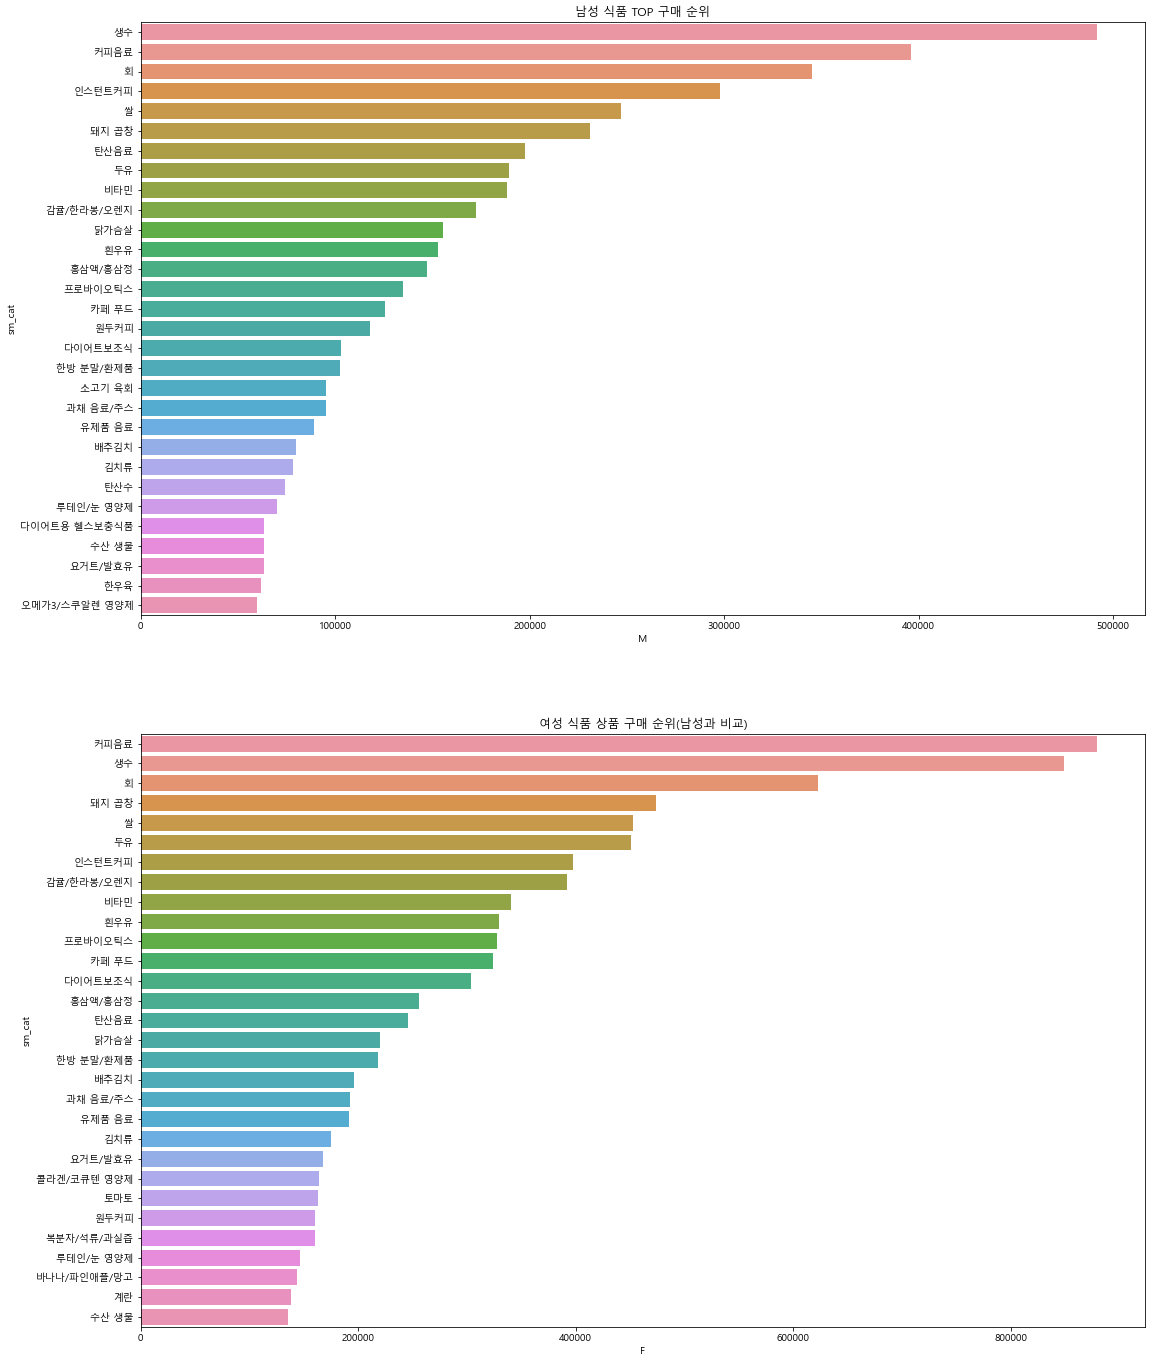

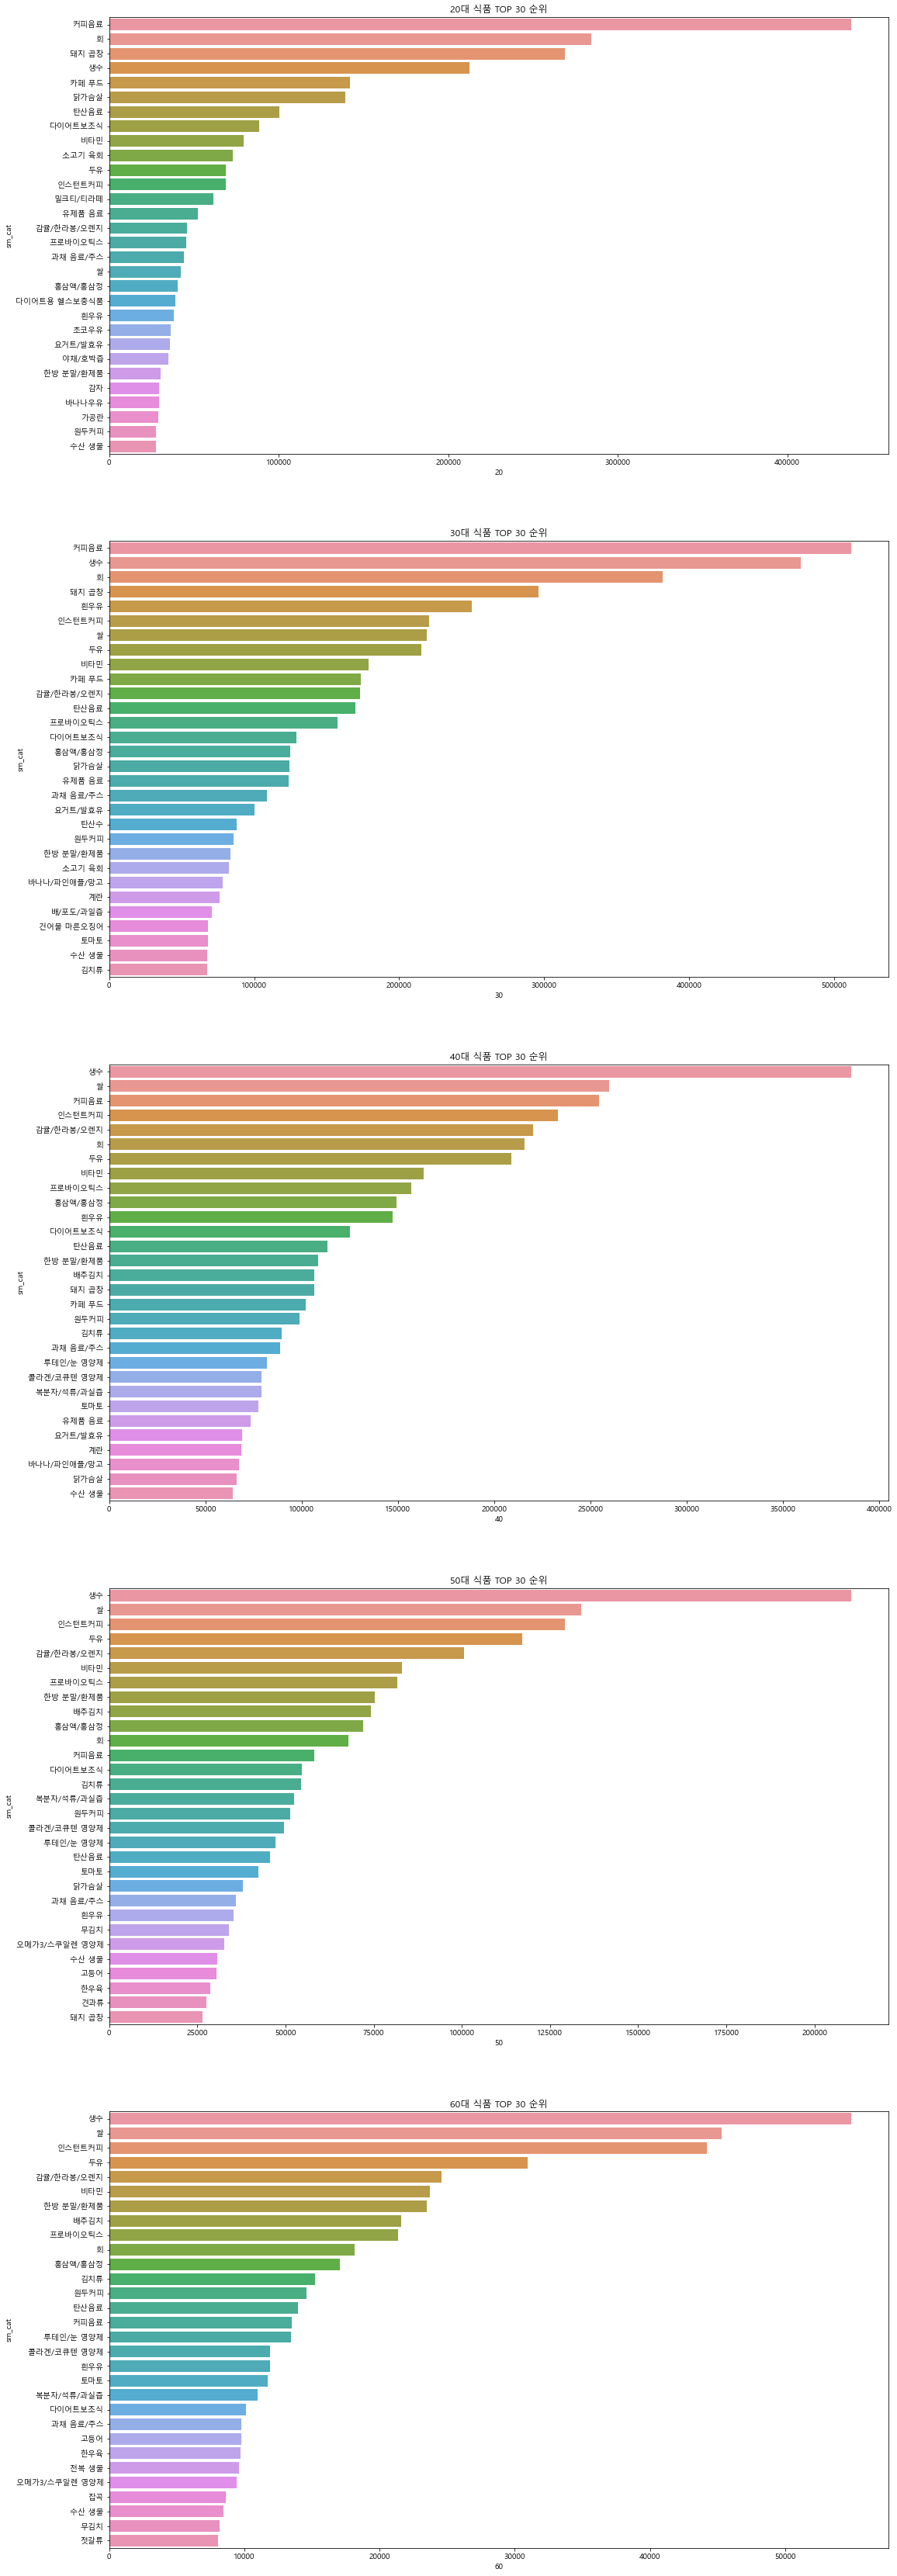

In [178]:
top30_buy("식품")

(2) 뷰티 中 상위 구매 건수 30개 항목(전체건수, 성별, 나이대별 구매 건수 상위 30개 항목)

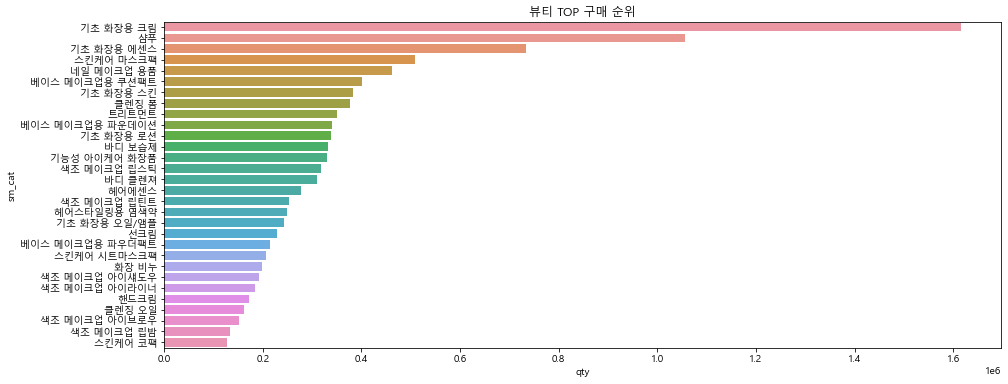

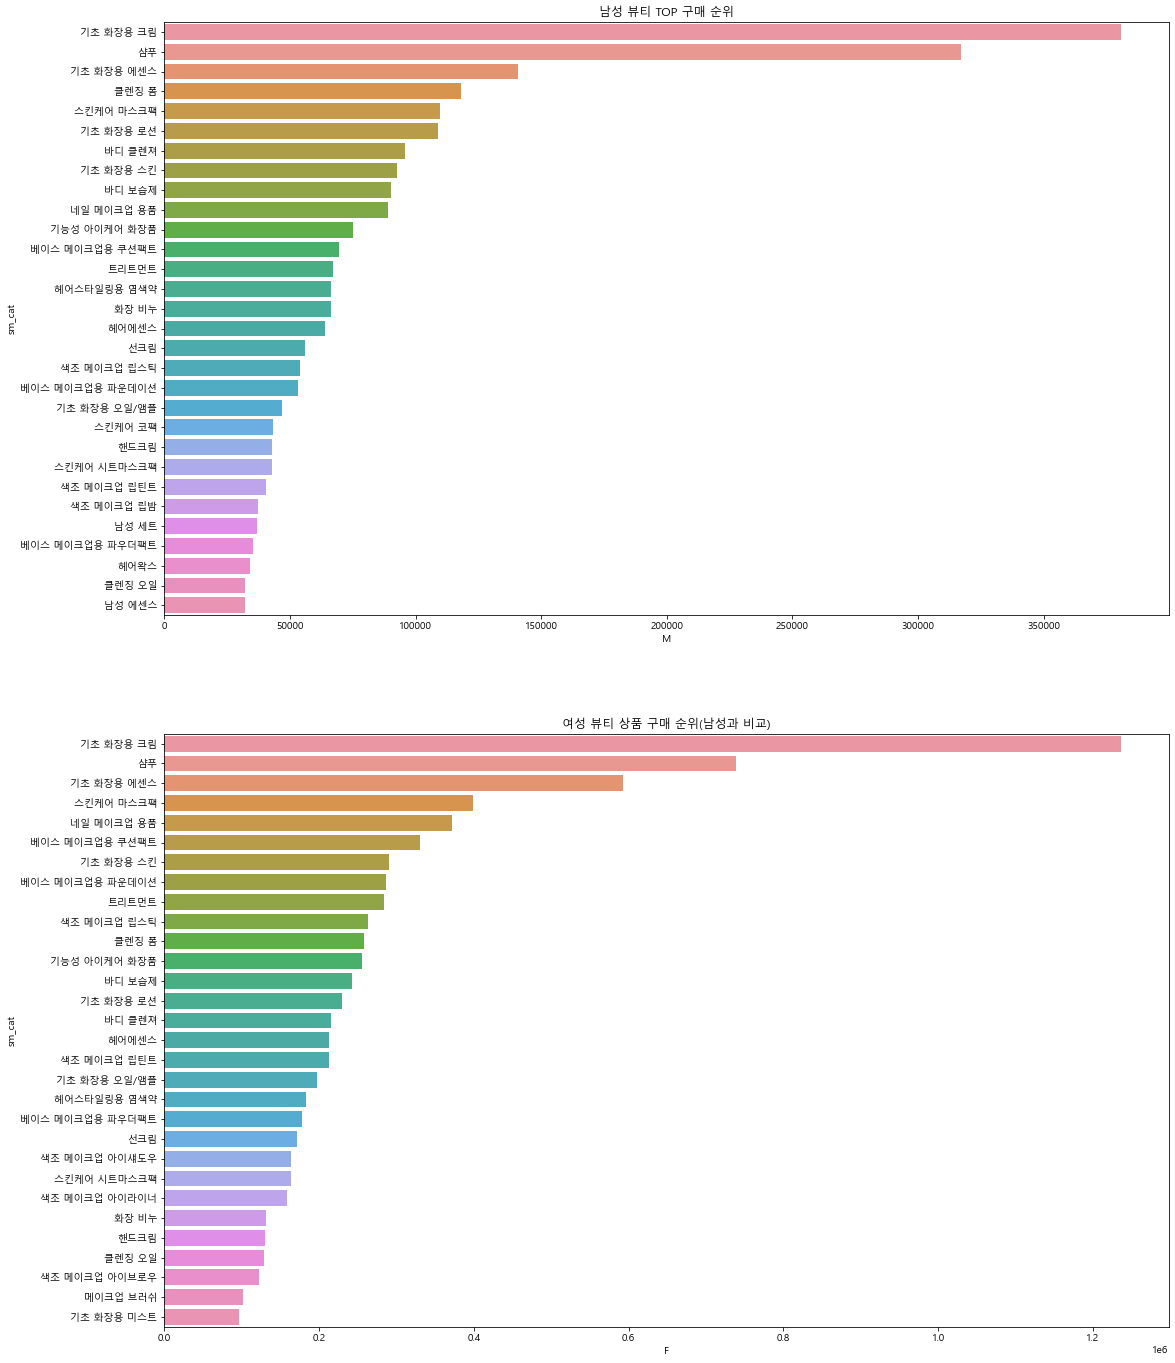

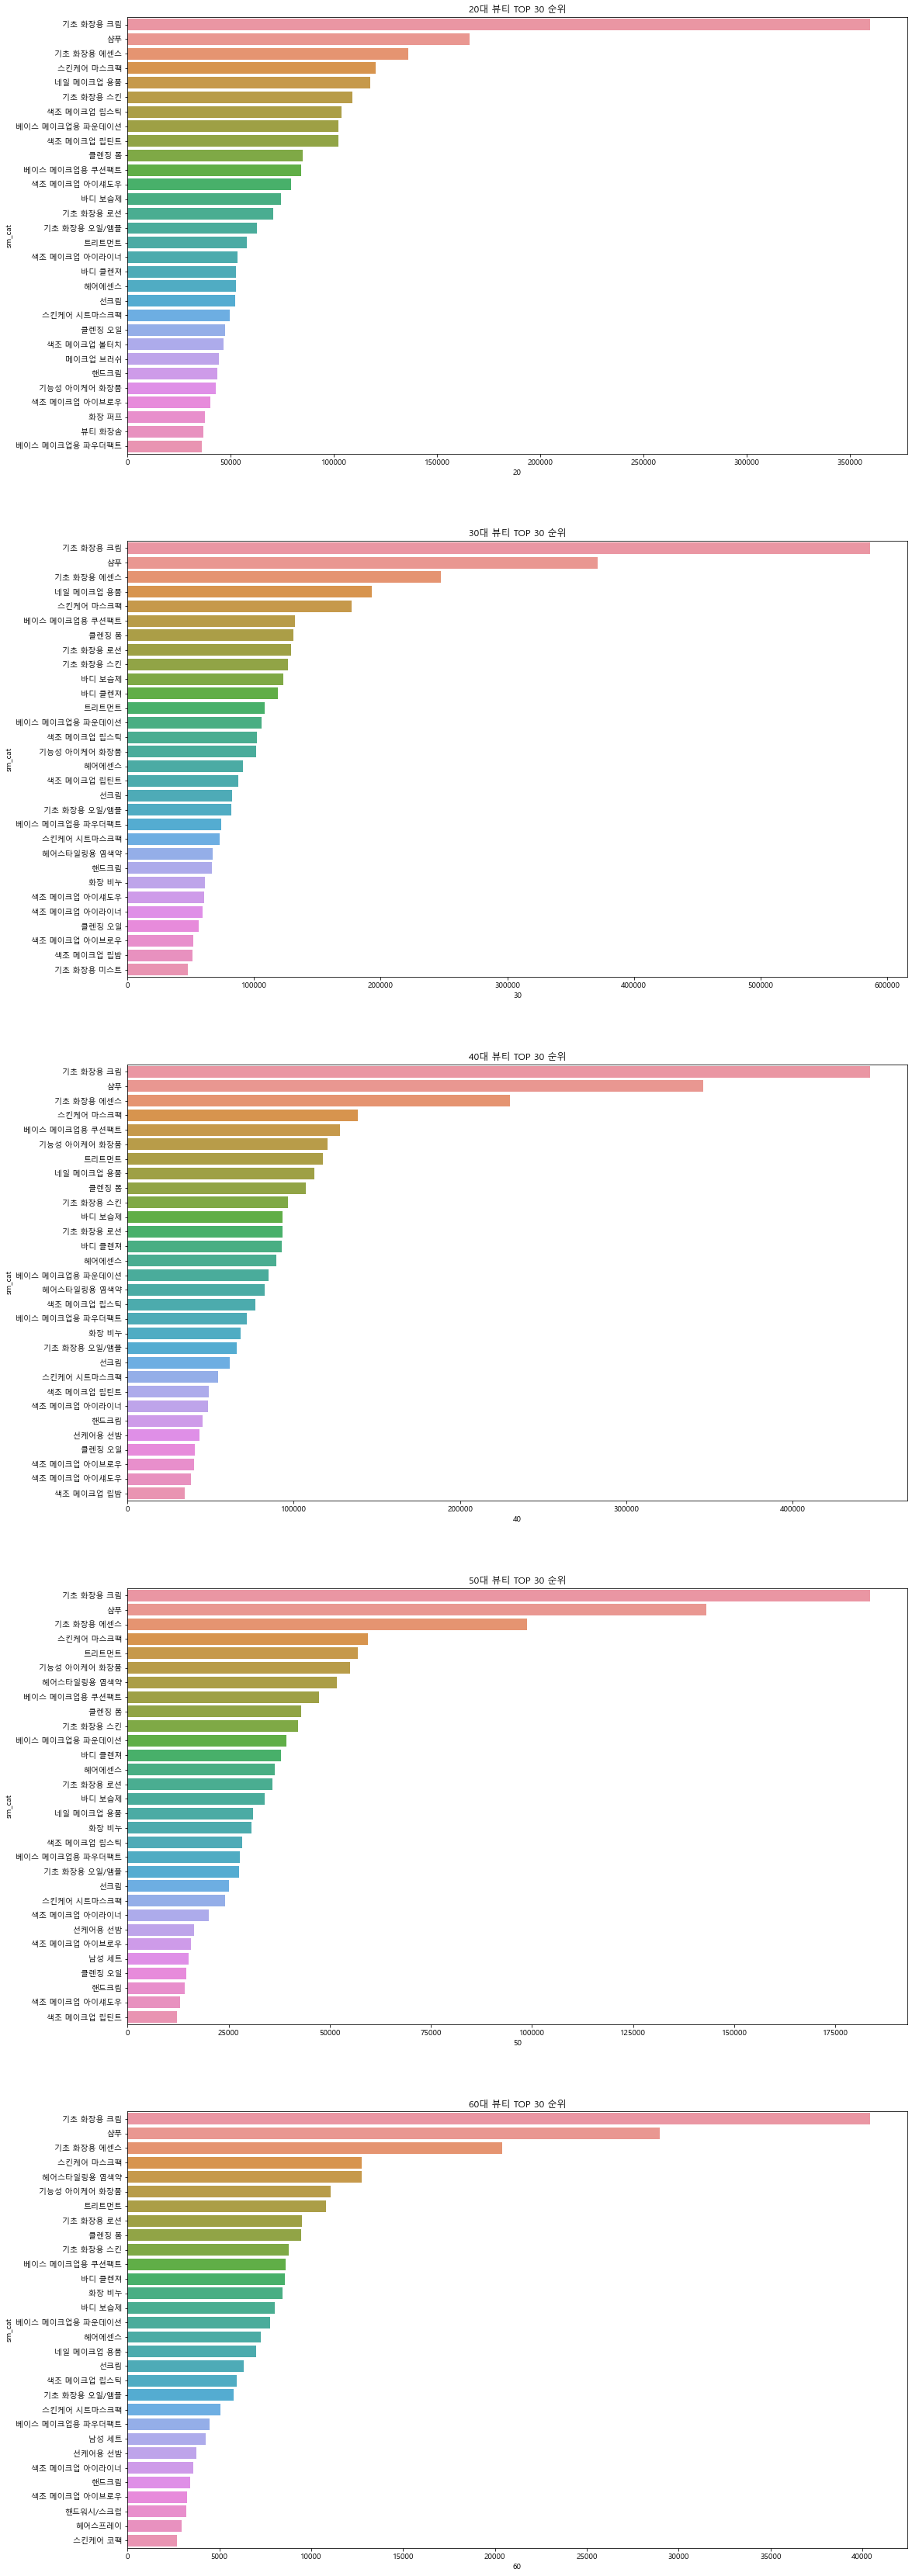

In [182]:
top30_buy("뷰티")

(3) 냉난방가전 中 상위 구매 건수 30개 항목(전체건수, 성별, 나이대별 구매 건수 상위 30개 항목)

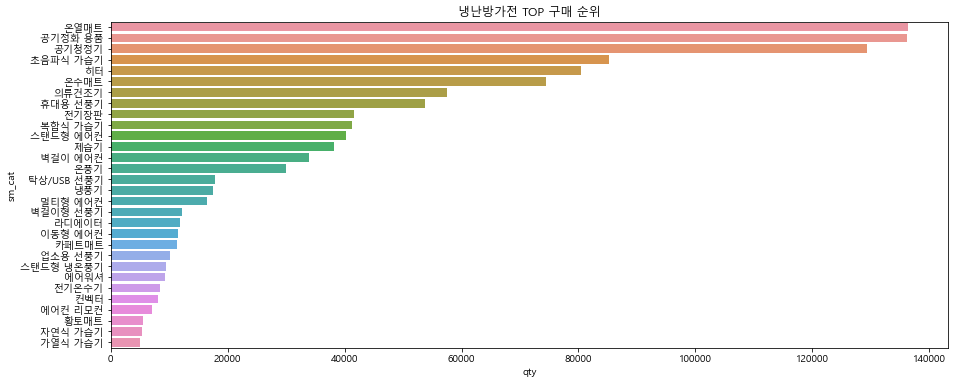

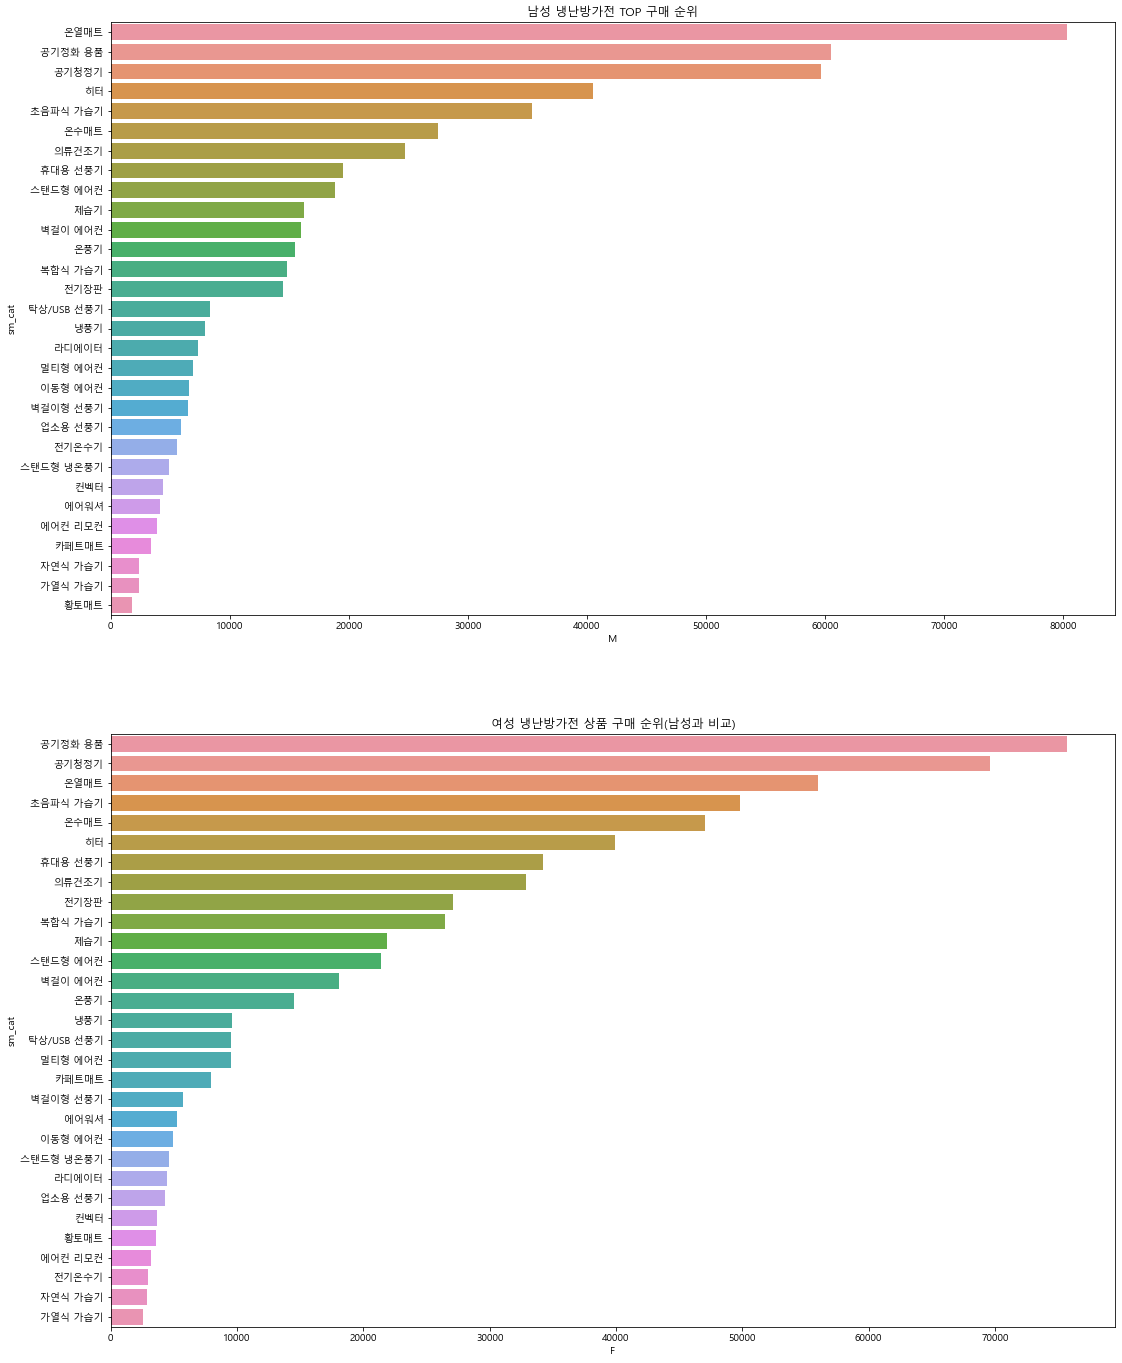

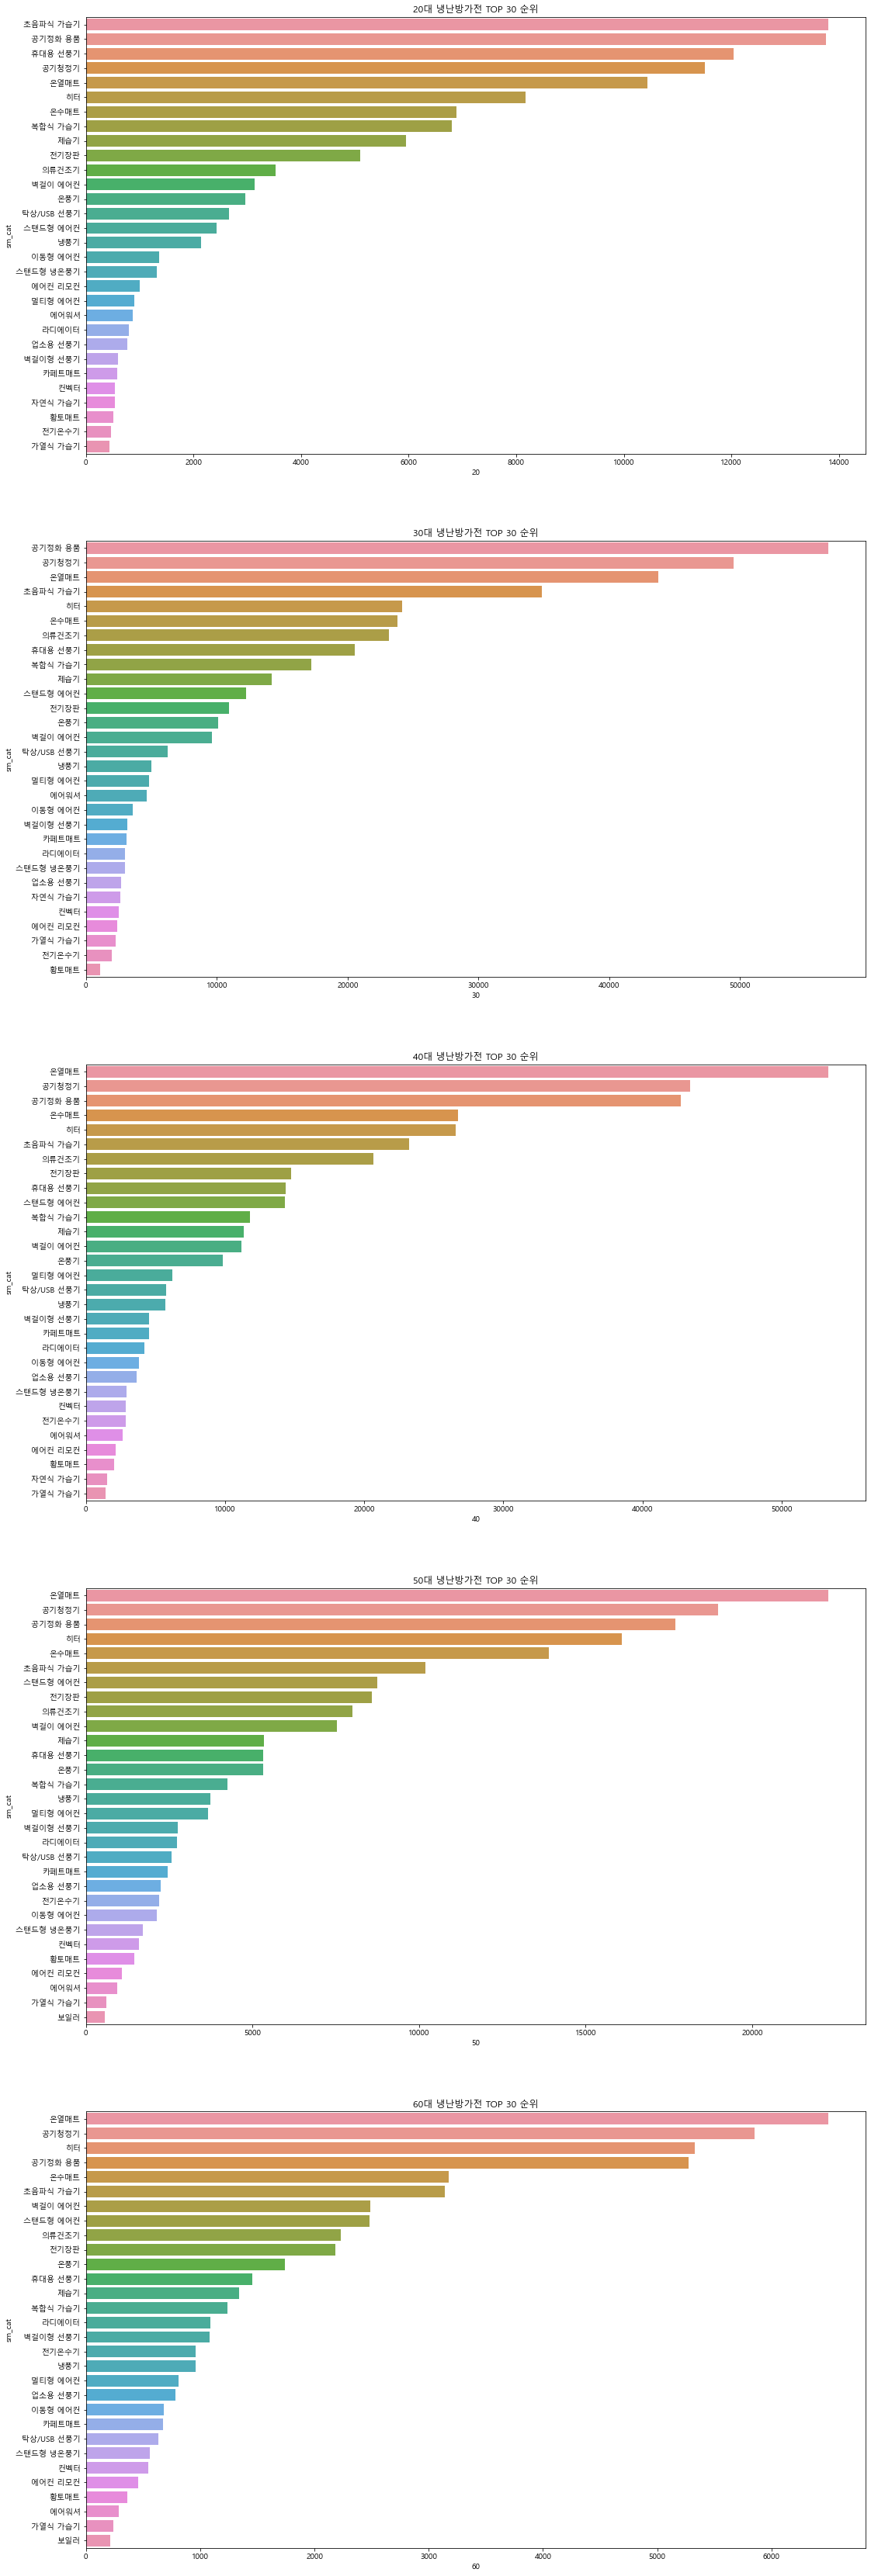

In [191]:
top30_buy("냉난방가전")

#### 6번 big_cat의 EDA(성별, 나이별 구매 건수 비율)

(1) 2년 동안의 각 상품별(대분류별) 판매 추이 및 이동 평균(5.30,60일)

In [229]:
time_buy = pd.pivot_table(buy_data, index= 'data', columns = 'big_cat', values = 'qty', aggfunc = 'sum').reset_index()

이동평균할 구간을 입력하세요.(완료되었으면 0을 입력하세요):15
이동평균할 구간을 입력하세요.(완료되었으면 0을 입력하세요):30
이동평균할 구간을 입력하세요.(완료되었으면 0을 입력하세요):0


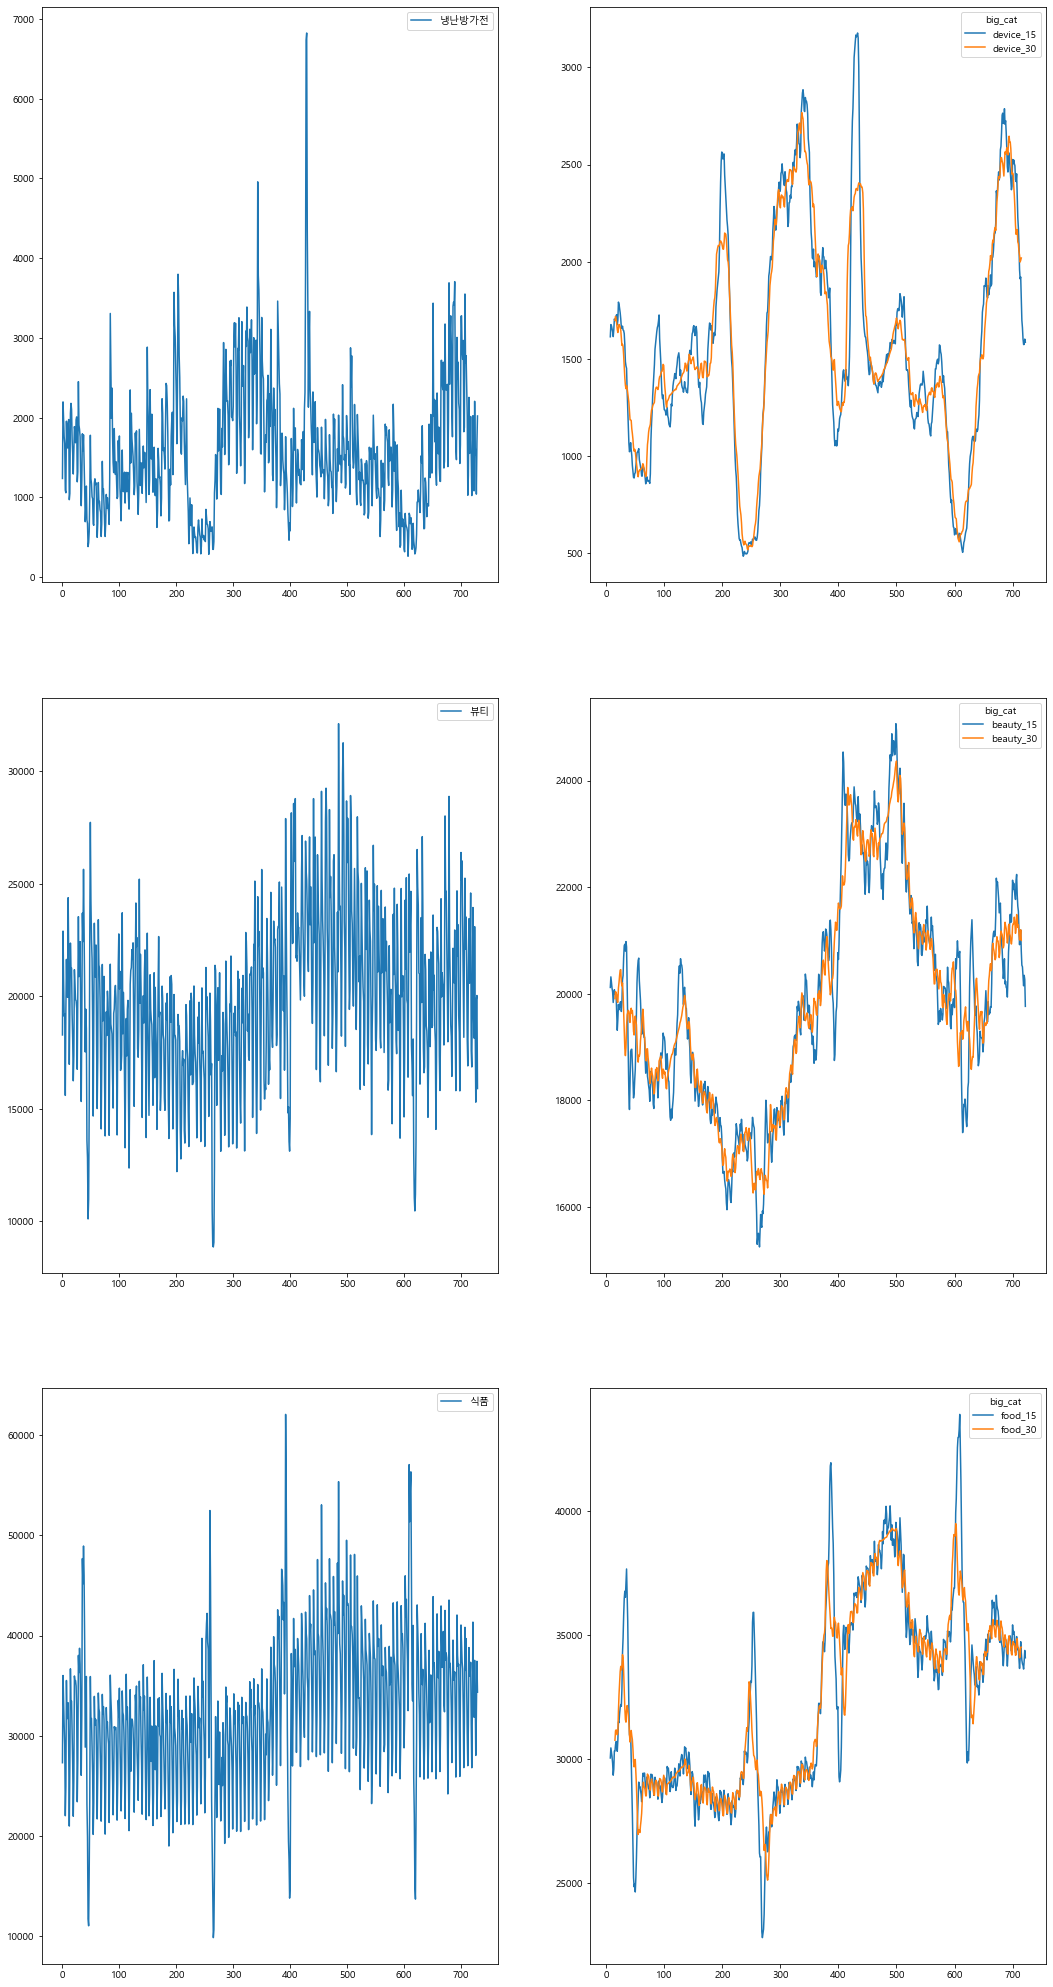

In [232]:
def move_age(need_list):
    device_list = []
    bueaty_list = []
    food_list = []
    for i in need_list:
        device = ("device_"+ str(i))
        device_list.append(device)
        bueaty = ("beauty_"+ str(i))
        bueaty_list.append(bueaty)
        food = ("food_"+ str(i))
        food_list.append(food)

        time_buy[device] = time_buy.냉난방가전.rolling(i, center=True).mean()
        time_buy[bueaty] = time_buy.뷰티.rolling(i, center=True).mean()
        time_buy[food] = time_buy.식품.rolling(i, center=True).mean()
        
    if len(need_list) !=0:
        fig, axes = plt.subplots(3,2, figsize = (18,36))
        time_buy.plot(y = "냉난방가전" ,ax = axes[0,0])
        time_buy.plot(y = device_list ,ax = axes[0,1])
        time_buy.plot(y = "뷰티", ax = axes[1,0])
        time_buy.plot(y = bueaty_list ,ax = axes[1,1])
        time_buy.plot(y = "식품" ,ax = axes[2,0])
        time_buy.plot(y = food_list ,ax = axes[2,1])
        plt.show()
    
num = []
while True:
    need = int(input("이동평균할 구간을 입력하세요.(완료되었으면 0을 입력하세요):"))
    if need == 0:
        break
    else:
        num.append(need)
        
move_age(num)

(2) 1년 나눠서 추이 파악

In [220]:
buy_data_2018 = buy_data.loc[buy_data.year == 2018,:]
buy_data_2019 = buy_data.loc[buy_data.year == 2019,:]
time_buy_2018 = pd.pivot_table(buy_data_2018, index= 'data', columns = 'big_cat', values = 'qty', aggfunc = 'sum').reset_index()
time_buy_2019 = pd.pivot_table(buy_data_2019, index= 'data', columns = 'big_cat', values = 'qty', aggfunc = 'sum').reset_index()

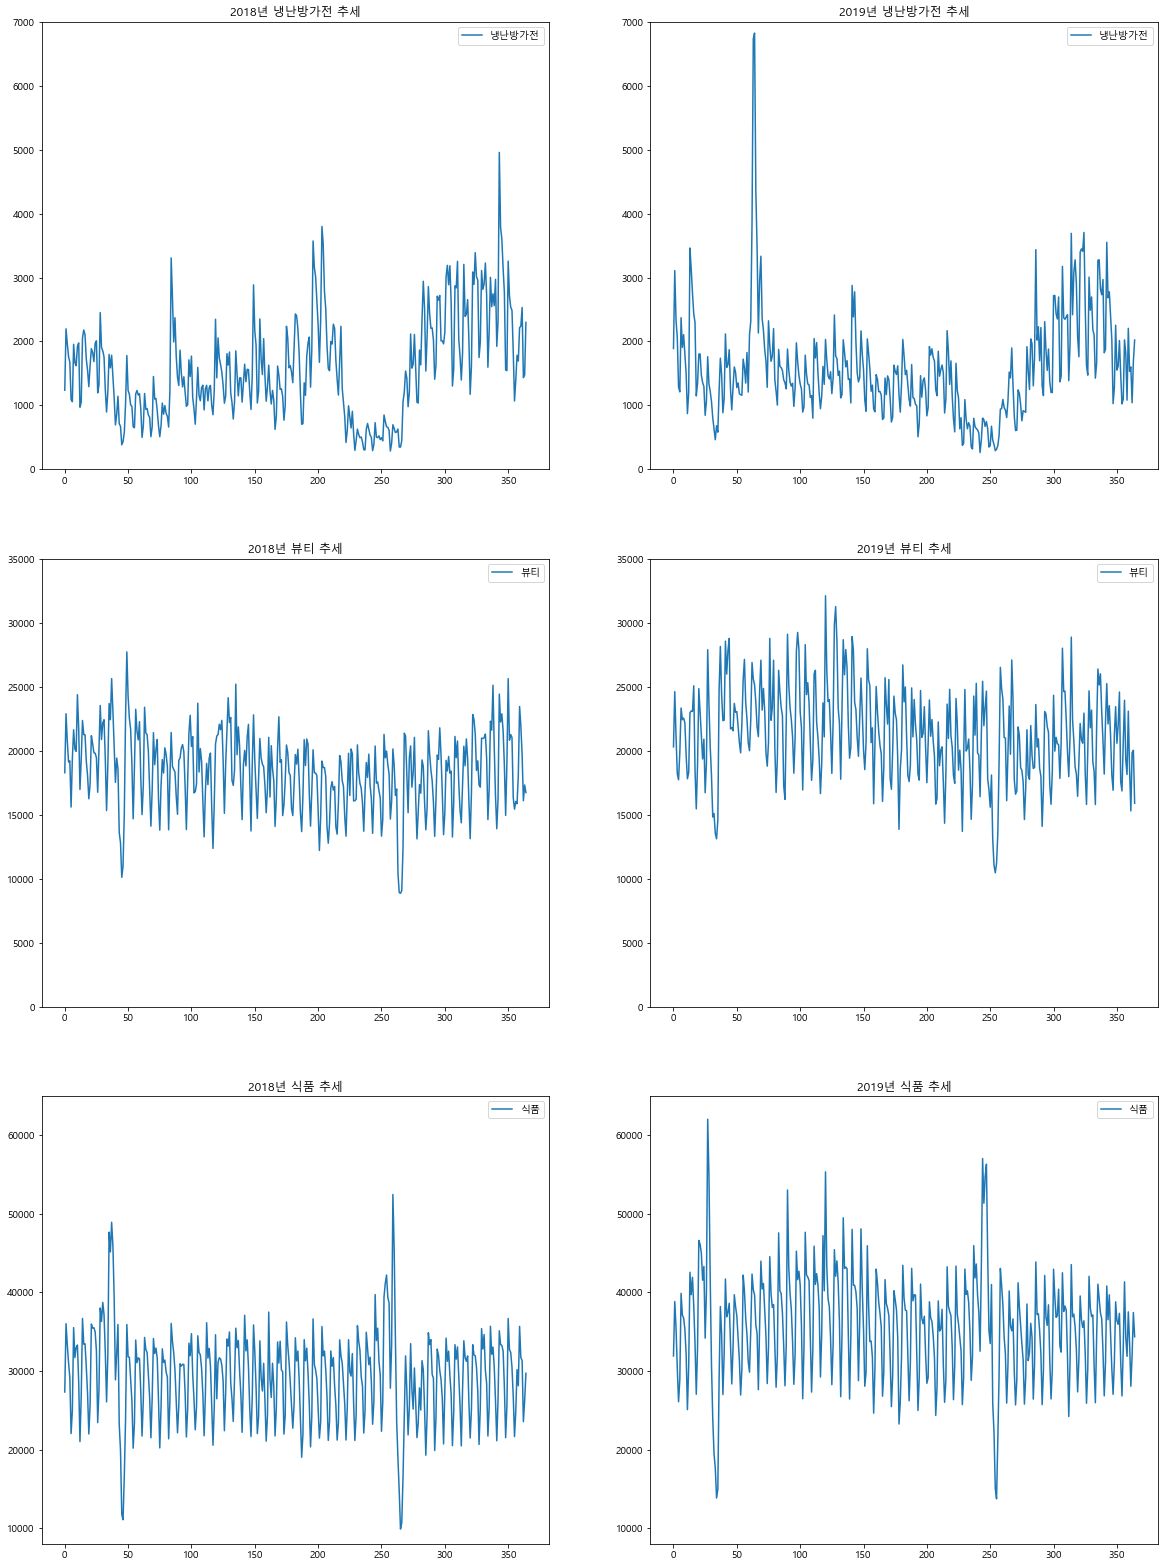

In [221]:
fig, axes = plt.subplots(3,2, figsize = (20,28))
lis = [[0,7000], [0, 35000], [8000, 65000]]

for i in range(3):
    col = time_buy_2018.iloc[:, i+1].name
    
    time_buy_2018.plot(y = col ,ax = axes[i,0])
    axes[i,0].set_title("2018년 {} 추세".format(col))
    axes[i,0].set_ylim(lis[i][0], lis[i][1])
    
    time_buy_2019.plot(y = col ,ax = axes[i,1])
    axes[i,1].set_title("2019년 {} 추세".format(col))
    axes[i,1].set_ylim(lis[i][0], lis[i][1])

#### (2) 차분하기 

차분할 구간을 입력하세요.(완료되었으면 0을 입력하세요):1
차분할 구간을 입력하세요.(완료되었으면 0을 입력하세요):15
차분할 구간을 입력하세요.(완료되었으면 0을 입력하세요):30
차분할 구간을 입력하세요.(완료되었으면 0을 입력하세요):0


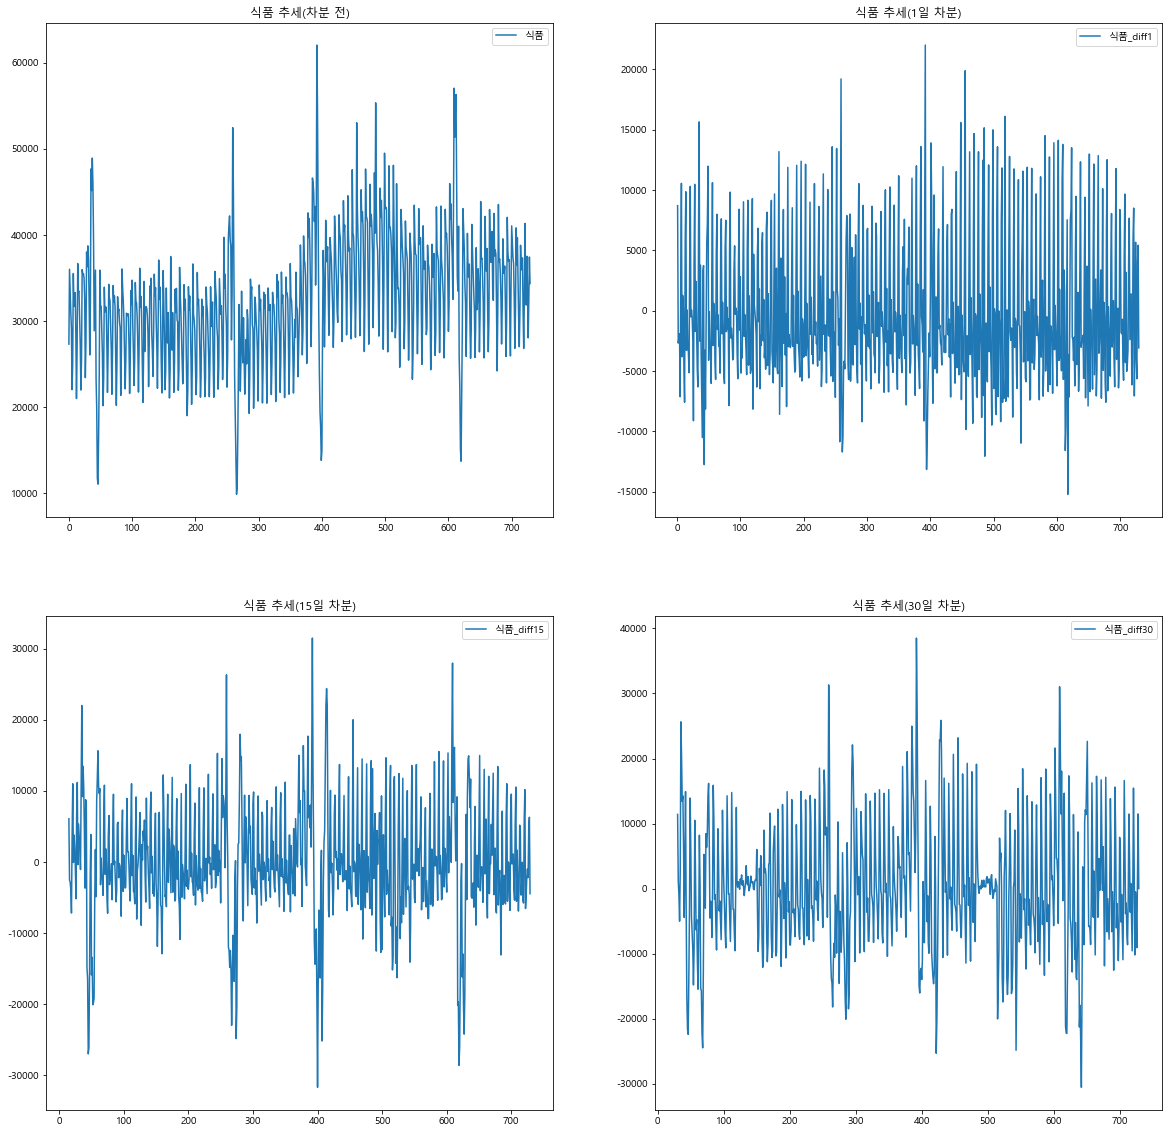

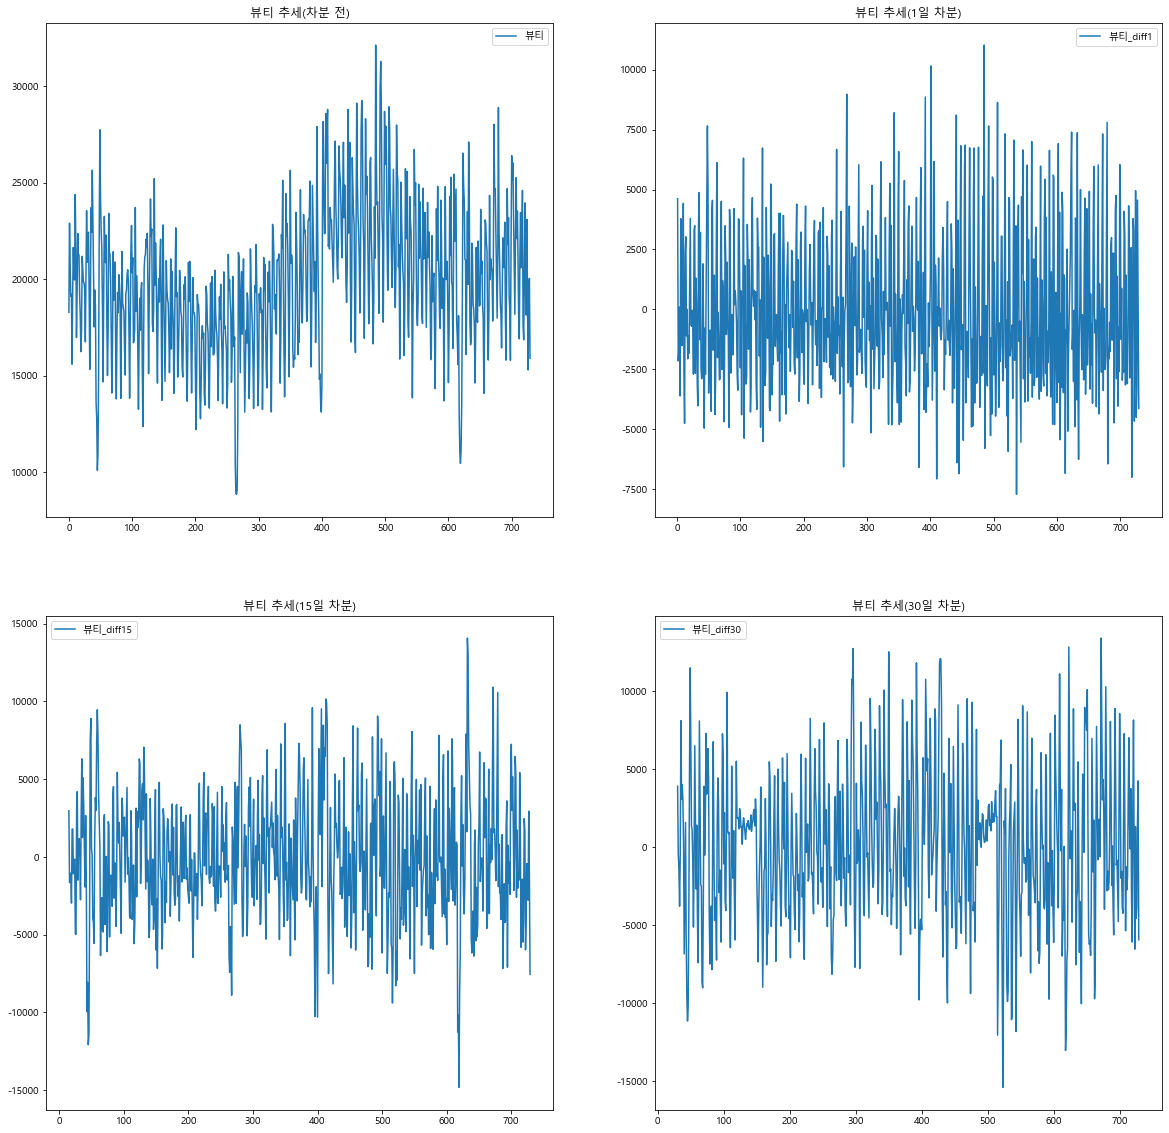

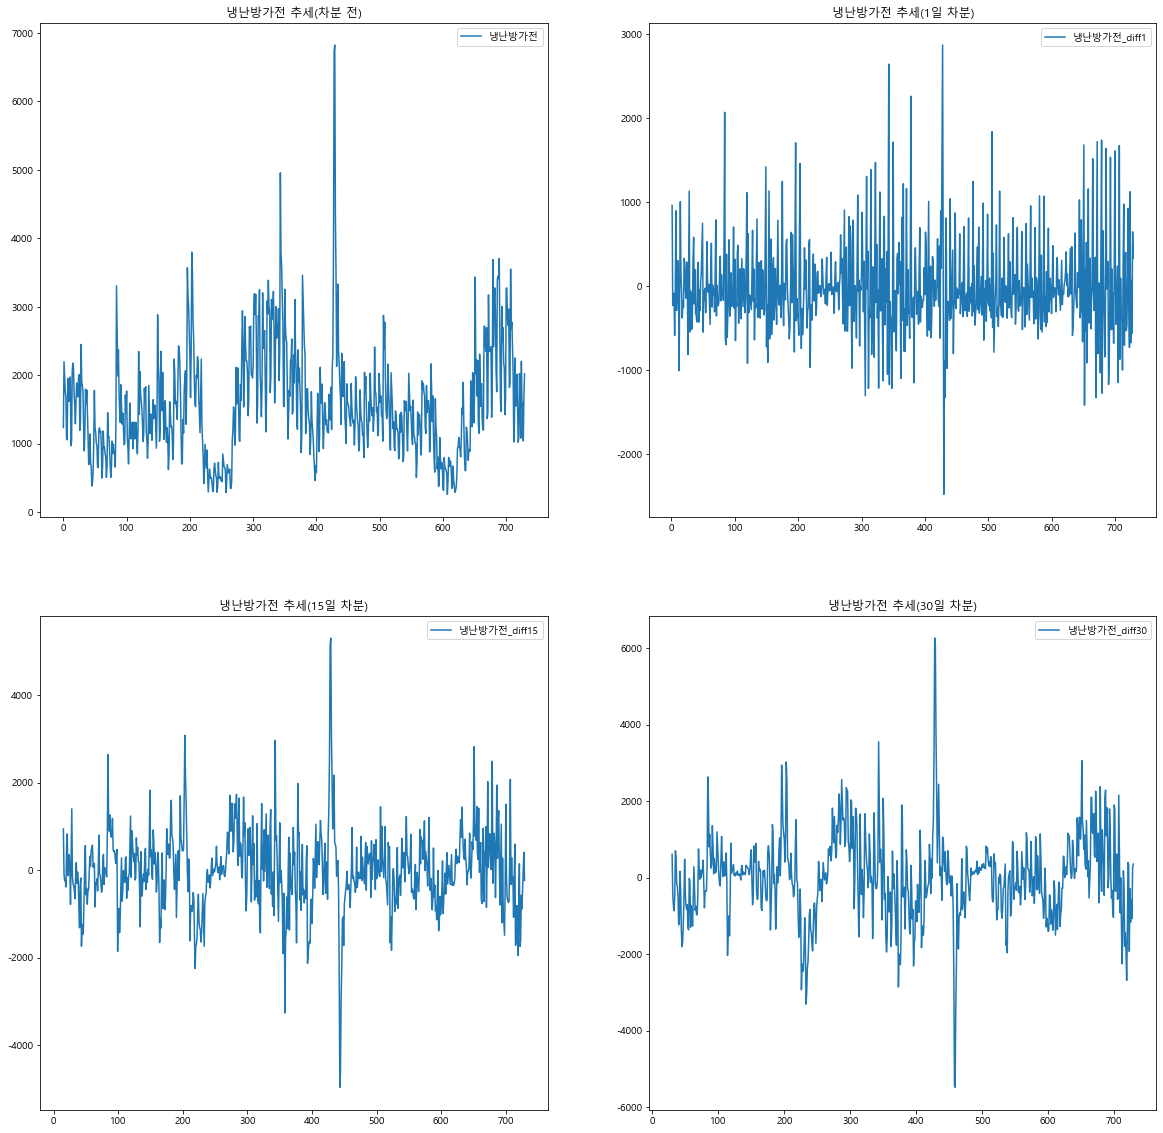

In [222]:
def move_age(need_list, big_cnt = ["식품","뷰티","냉난방가전"]):
    for i in big_cnt:
        col_name_list = []
        for j in need_list:
            col_name = i + "_diff" + str(j)
            col_name_list.append(col_name)
            time_buy[col_name] = time_buy[i].diff(periods = j)    
    
        fig, axes = plt.subplots(2,2, figsize = (20,20))
        
        time_buy.plot(y = time_buy[i].name, ax = axes[0,0])
        axes[0,0].set_title("{} 추세(차분 전)".format(i))
        
        time_buy.plot(y = col_name_list[0], ax = axes[0,1])
        axes[0,1].set_title("{} 추세({}일 차분)".format(i, need_list[0]))
        
        time_buy.plot(y =  col_name_list[1], ax = axes[1,0])
        axes[1,0].set_title("{} 추세({}일 차분)".format(i, need_list[1]))
        
        time_buy.plot(y =  col_name_list[2], ax = axes[1,1])
        axes[1,1].set_title("{} 추세({}일 차분)".format(i, need_list[2]))
        
        plt.show()
    
    
num = []
while True:
    need = int(input("차분할 구간을 입력하세요.(완료되었으면 0을 입력하세요):"))
    if need == 0:
        break
    else:
        num.append(need)
        
move_age(num)

In [223]:
time_buy

big_cat,data,냉난방가전,뷰티,식품,device_1,beauty_1,food_1,device_15,beauty_15,food_15,...,food_30,식품_diff1,식품_diff15,식품_diff30,뷰티_diff1,뷰티_diff15,뷰티_diff30,냉난방가전_diff1,냉난방가전_diff15,냉난방가전_diff30
0,20180101,1238,18284,27326,1238.0,18284.0,27326.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20180102,2198,22900,36024,2198.0,22900.0,36024.0,NaN,NaN,NaN,...,NaN,8698.0,NaN,NaN,4616.0,NaN,NaN,960.0,NaN,NaN
2,20180103,1967,20749,33346,1967.0,20749.0,33346.0,NaN,NaN,NaN,...,NaN,-2678.0,NaN,NaN,-2151.0,NaN,NaN,-231.0,NaN,NaN
3,20180104,1761,19117,31066,1761.0,19117.0,31066.0,NaN,NaN,NaN,...,NaN,-2280.0,NaN,NaN,-1632.0,NaN,NaN,-206.0,NaN,NaN
4,20180105,1677,19210,29163,1677.0,19210.0,29163.0,NaN,NaN,NaN,...,NaN,-1903.0,NaN,NaN,93.0,NaN,NaN,-84.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,20191227,1533,18595,33690,1533.0,18595.0,33690.0,NaN,NaN,NaN,...,NaN,-3845.0,-999.0,-3248.0,-4503.0,-2580.0,-4585.0,-673.0,-883.0,-1163.0
726,20191228,1602,15297,28055,1602.0,15297.0,28055.0,NaN,NaN,NaN,...,NaN,-5635.0,-2195.0,-9089.0,-3298.0,-2777.0,-3843.0,69.0,-423.0,-583.0
727,20191229,1042,19856,32020,1042.0,19856.0,32020.0,NaN,NaN,NaN,...,NaN,3965.0,4994.0,1264.0,4559.0,2947.0,1465.0,-560.0,14.0,-1062.0
728,20191230,1688,20038,37444,1688.0,20038.0,37444.0,NaN,NaN,NaN,...,NaN,5424.0,6301.0,11486.0,182.0,-1192.0,4241.0,646.0,409.0,262.0


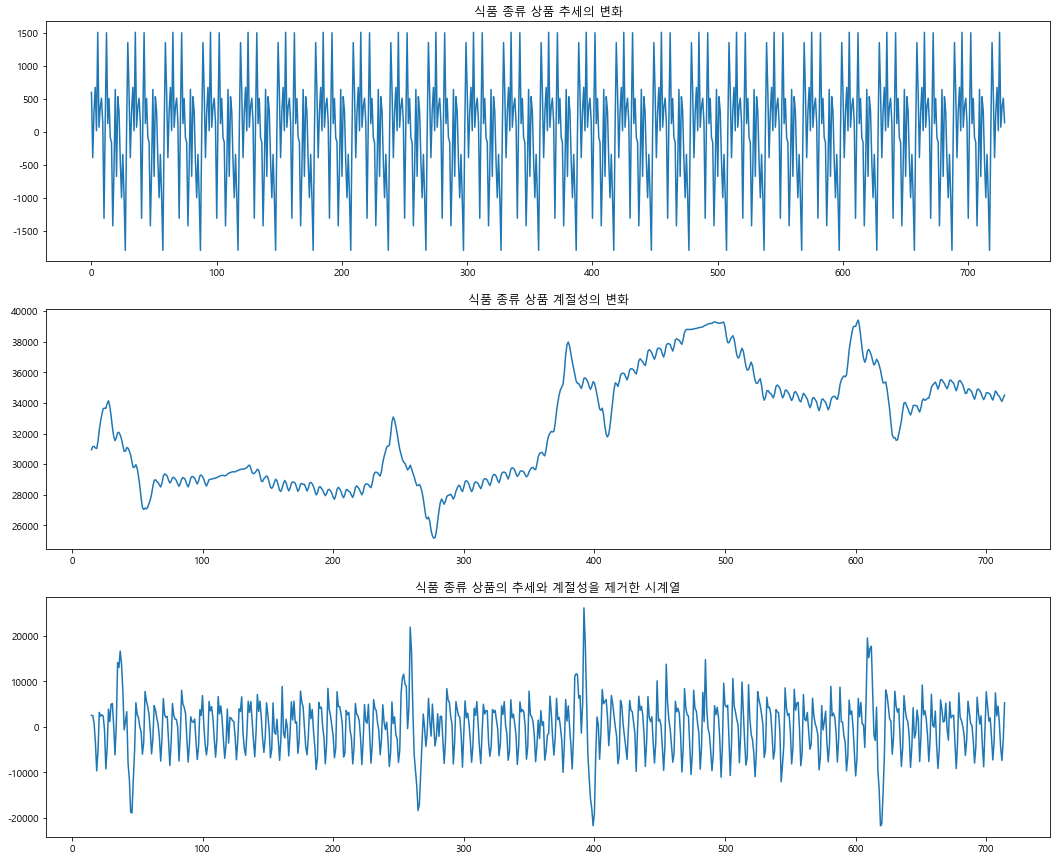

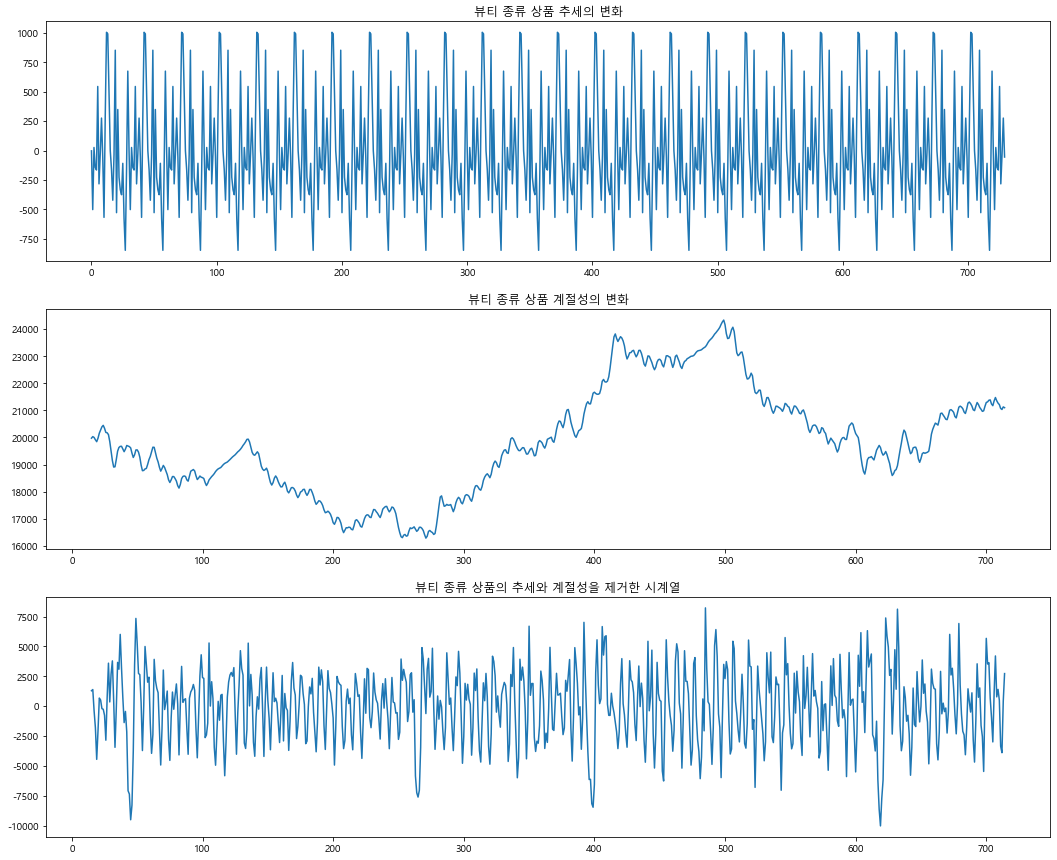

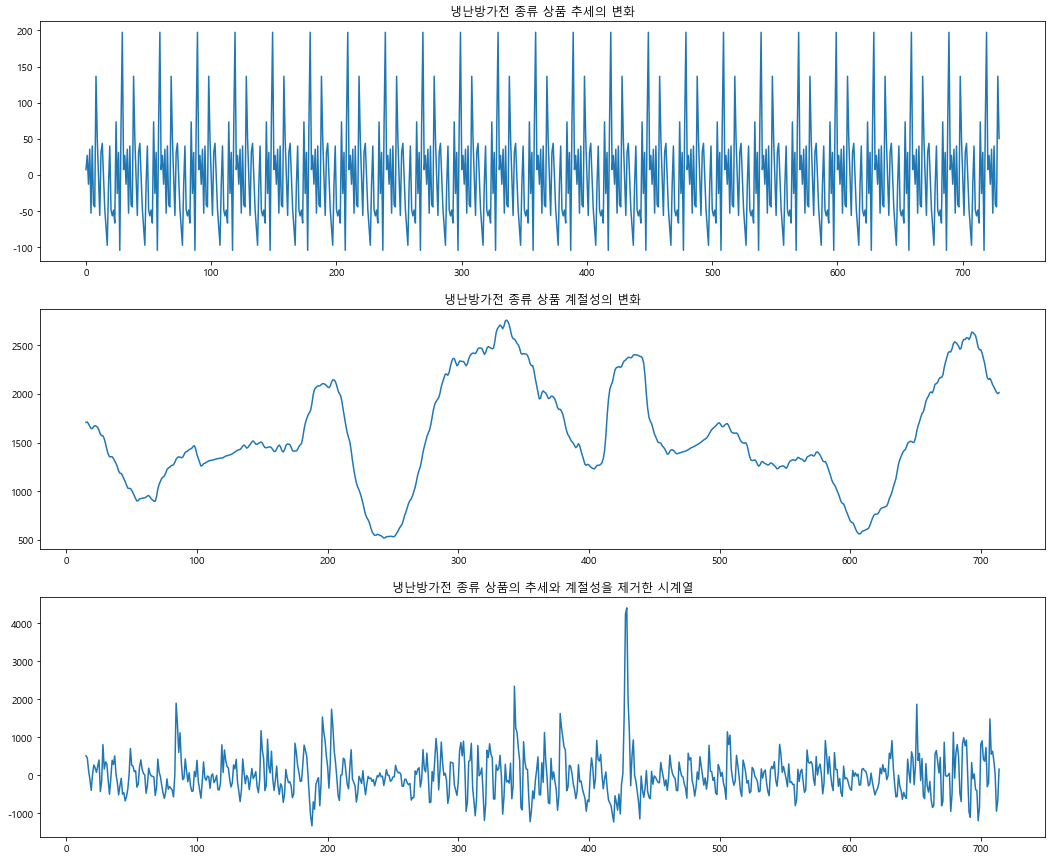

In [228]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i in ["식품","뷰티","냉난방가전"]:
    result = seasonal_decompose(time_buy[i], model='additive', period=30)

    fig, axes = plt.subplots(3,1, figsize = (18, 15))

    result.seasonal.plot(ax = axes[0])
    axes[0].set_title("{} 종류 상품 추세의 변화".format(i))

    result.trend.plot(ax = axes[1])
    axes[1].set_title("{} 종류 상품 계절성의 변화".format(i))

    result.resid.plot(ax = axes[2])
    axes[2].set_title("{} 종류 상품의 추세와 계절성을 제거한 시계열".format(i))

plt.show()